In [1]:
import pydotplus 
from sklearn.datasets.mldata import fetch_mldata
import numpy as np
import tempfile
import urllib
from matplotlib import pyplot as plt
from IPython.display import Image  
from sklearn import model_selection
%matplotlib inline
from sklearn import tree
from sklearn.metrics import accuracy_score, classification_report
from sklearn.cross_validation import train_test_split
import pandas as pd


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
url="http://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data-numeric" 
raw_data = urllib.request.urlopen(url) 
credit=np.genfromtxt(raw_data) 
X,y = credit[:,:-1], credit[:,-1:].squeeze() 
train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size = 0.25, random_state = 1)

In [3]:
clf = tree.DecisionTreeClassifier(max_depth=3)

In [4]:
clf.fit(train_data, train_labels)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [5]:
# get feature names
url="http://freakonometrics.free.fr/german_credit.csv"
credit=pd.read_csv(url, sep = ",")

features = []
for i in credit:
    features.append(i)
print(features)

['Creditability', 'Account Balance', 'Duration of Credit (month)', 'Payment Status of Previous Credit', 'Purpose', 'Credit Amount', 'Value Savings/Stocks', 'Length of current employment', 'Instalment per cent', 'Sex & Marital Status', 'Guarantors', 'Duration in Current address', 'Most valuable available asset', 'Age (years)', 'Concurrent Credits', 'Type of apartment', 'No of Credits at this Bank', 'Occupation', 'No of dependents', 'Telephone', 'Foreign Worker']


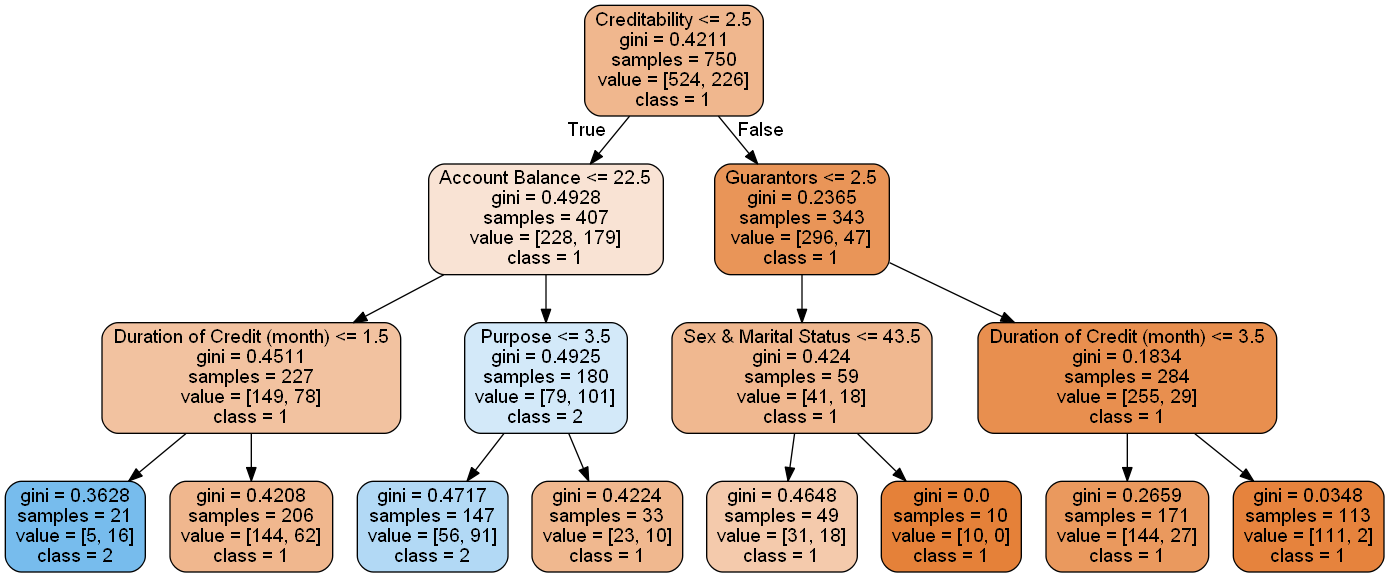

In [6]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names = features,
                         class_names = ['1','2'],
                         filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [7]:
# class = 1 - good (confirm credit)
# class = 2 - bad (reject credit)

#### Проинтерпретируем первые несколько разбиений.
Видно, что кредит не выдают, если у человека 
а) низкая кредитоспособность, мало денег на счету и он берет кредит на короткий срок (скорее всего на покупку, а не вложение денег в бизнес, раз срок небольшой).
б) низкая кредитоспособность, мало денег на счету и он берет кредит на покупку вещей (машины, бытовой техники)

#### Построим графики зависимости на кросс валидации на выборке от глубины дерева.

In [8]:
cvs = []
train_score = []
for depth in range(1, 10):
    clf = tree.DecisionTreeClassifier(max_depth = depth)
    clf.fit(train_data, train_labels)
    score = np.mean(model_selection.cross_val_score(clf, train_data, train_labels))
    train_score.append(accuracy_score(clf.predict(test_data), test_labels))

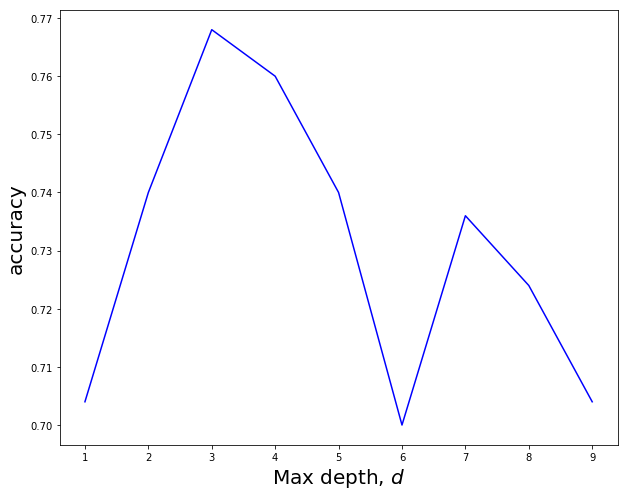

In [9]:
plt.figure(figsize=(10, 8))
plt.xlabel(r"Max depth, $d$", fontsize=20)
plt.ylabel(r"accuracy", fontsize=20)
plt.plot(range(1, len(train_score) + 1), train_score, c='blue')

In [10]:
from sklearn.datasets import load_boston
import numpy as np
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor

%matplotlib inline

In [11]:
boston = load_boston()
X = boston.data
y = boston.target

In [12]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, answer=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.answer = answer

In [13]:
class DecisionTreeRegressor:
    
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.cur_depth = 0
        
    # X - objects, Y - answers    
    def build_tree(self, X, Y, cur_depth):
        f_index, trhld, x_left, y_left, x_right, y_right = self.get_split_of_node(X, Y)
        if cur_depth <= self.max_depth and y_left is not None and y_right is not None:
            left_son = self.build_tree(x_left, y_left, cur_depth + 1)
            right_son = self.build_tree(x_right, y_right, cur_depth + 1)
            return Node(feature = f_index, threshold=trhld, left=left_son, right=right_son)
        return Node(answer=np.mean(Y))
    
    
    def get_split_of_node(self, x, y):
        inform_min = np.inf
        f_index, trhld, x_left, y_left, x_right, y_right = [None] * 6
        for feature_index in range(len(X[0])):
            thresholds = get_thresholds(X, feature_index)
            for t in thresholds:
                x1, y1, x2, y2 = self.split_by_treshold(x, y, feature_index, t)
                if len(y1) > 0 and len(y2) > 0:
                    inform = self.inform_of_split(y, y1, y2)
                    if inform < inform_min:
                        inform_min = inform
                        x_left = x1
                        y_left = y1
                        x_right = x2
                        y_right = y2
                        trhld = t
                        f_index = feature_index
        return f_index, trhld, x_left, y_left, x_right, y_right
    
    #compute (|y1|/|y|)*H(y1) + (|y2|/|y|)*H(y2) - "badness" of split
    def inform_of_split(self, y, y1, y2):
        return 1.0 * get_deviation(y1) * len(y1) / len(y) + 1.0 * get_deviation(y2) * len(y2) / len(y)
    
    def split_by_treshold(self, X, y, feature_index, treshold):
        X1 = []
        y1 = []
        X2 = []
        y2 = []
        for i in range(len(X)):
            if X[i][feature_index] < treshold:
                X1.append(X[i])
                y1.append(y[i])
            else:
                X2.append(X[i])
                y2.append(y[i])
        return np.array(X1), np.array(y1), np.array(X2), np.array(y2)
    
    def fit(self, x, y):
        self.root = self.build_tree(x, y, 0)
    
    def go_through_tree(self, x, cur_node=None):
        if cur_node is None:
            cur_node = self.root
        if cur_node.answer is not None:
            return cur_node.answer
        son_node = cur_node.right
        if x[cur_node.feature] < cur_node.threshold:
            son_node = cur_node.left
        return self.go_through_tree(x, son_node)
    def predict(self, X):
        res = []
        for x in X:
            res.append(self.go_through_tree(x))
        return np.array(res)

In [14]:
# We will use Mean Absolute Error as an measure of error
def get_deviation(y): 
    return np.mean(abs(y-np.mean(y)))

# check all unique values of certain feature as thresholds (unique values = tresholds)
def get_thresholds(X, feature_index):
    feature_values = np.expand_dims(X[:, feature_index], axis=1)
    unique_values = np.unique(feature_index)
    return unique_values

In [15]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y)

In [16]:
HandmadeTree = DecisionTreeRegressor(max_depth=30)
HandmadeTree.fit(X_train, y_train)
print(np.mean((y_test - HandmadeTree.predict(X_test))**2)/len(y_test))

0.389337853437


In [17]:
SklearnTree = DecisionTreeRegressor(criterion = 'mae', max_depth=30)
SklearnTree.fit(X_train, y_train)
print(np.mean((y_test - SklearnTree.predict(X_test))**2)/len(y_test))

TypeError: __init__() got an unexpected keyword argument 'criterion'

Постоим график ошибки от максимальной глубины дерева

In [ ]:
test_score = []
depths = [i for i in range(1,20)]
for depth in depths:
    tree = DecisionTreeRegressor(max_depth = depth)
    tree.fit(X_train, y_train)
    test_score.append(np.mean((y_test - tree.predict(X_test))**2)/len(y_test))

plt.figure(figsize=(10, 8))
plt.xlabel(r"Max depth, $d$", fontsize=20)
plt.ylabel(r"MSE score", fontsize=20)
plt.plot(depths, test_score)